# Создание многоклассового классификатора изображений по типу эмоций:
**Имеются 7 типов эмоций** <br>

## Дано:
В архиве "all.zip" лежит папка all, в которой массив фотографий людей, показывающих различные виды эмоций (для самостоятельного запуска кода архив необходимо скачать по ссылке и после разархивации папку all положить в репозитоий проекта)<br>
В репозитории уже имеется файл _label_dataset.csv_, в котором находится код соответсвующей эмоции для каждого номера фотографии из папки "all", которая появляется в текущей директории проекта при запуске кода: <br>
0 - neutral,<br>
1 - anger,<br>
2 - contempt,<br>
3 - disgust,<br>
4 - fear,<br>
5 - happiness,<br>
6- surprise<br>


Загрузить архив _all.zip_ с фотографиями можно по данной ссылке. После загрузки и разархивации папку _all_ надо положить в репозитоий проекта, где уже лежат файлы _emotion_class_binar.ipynb_, _emotion_class_multy.ipynb_  и _label_dataset.csv_
<a href="https://drive.google.com/file/d/1fdDs9fHt79Lkoo-HRzIsMdwugeQ96Nwg/view?usp=share_link" target="blank"><img align="center" src="http://cdn.onlinewebfonts.com/svg/img_317646.png" alt="kolesnokov__dima" height="50" width="50" /> </a> 

Работу выполнил **Колесников Дмитрий**

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import cv2
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter

import PIL.Image
import PIL.ImageDraw

import collections
from matplotlib import pyplot
import pylab as pl
import glob
import zipfile

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

In [2]:
#!pip install face_recognition 

In [3]:
import face_recognition as fr

In [4]:
path = os.getcwd()

In [5]:
list_im = os.listdir('all')

Загрузим датафрейм и посмотрим его содержимое:

In [6]:
df = pd.read_csv('label_dataset.csv', index_col=0)

In [7]:
df.shape

(920, 2)

In [8]:
df.head()

,label,file name
0,1,S010_004_00000019.png
1,1,S011_004_00000021.png
2,1,S014_003_00000030.png
3,1,S022_005_00000032.png
4,1,S026_003_00000015.png


In [9]:
dirName = 'all'
allFiles = list()
for entry in list_im:
    fullPath = os.path.join(dirName, entry)
    if os.path.isdir(fullPath):
        allFiles = allFiles + getListOfFiles(fullPath)
    else:
        allFiles.append(fullPath)             

Получим список фотографий для каждого номера эмоции:

In [10]:
df_new = df.groupby('label', as_index = False)['file name'].\
    apply(np.asarray).to_frame().reset_index().\
    rename(columns={"index": "category", 'file name': 'file'})
df_new

,category,file
0,0,"[S005_001_00000001.png, S010_001_00000001.png,..."
1,1,"[S010_004_00000019.png, S011_004_00000021.png,..."
2,2,"[S138_008_00000009.png, S139_002_00000013.png,..."
3,3,"[S005_001_00000011.png, S011_005_00000020.png,..."
4,4,"[S011_003_00000014.png, S032_004_00000014.png,..."
5,5,"[S010_006_00000015.png, S011_006_00000013.png,..."
6,6,"[S010_002_00000014.png, S011_001_00000016.png,..."


Продемонстрируем как пример виды эмоций по имеющимся фото из папки all:

S005_001_00000001.png
S010_004_00000019.png
S138_008_00000009.png
S005_001_00000011.png
S011_003_00000014.png
S010_006_00000015.png
S010_002_00000014.png


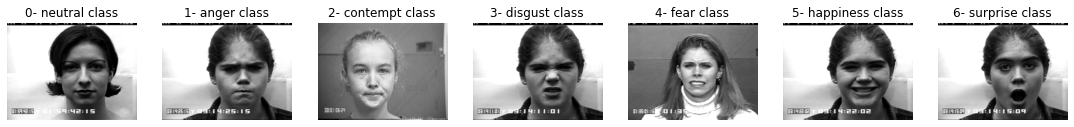

In [11]:
names = ['0- neutral', '1- anger', '2- contempt', '3- disgust',
         '4- fear', '5- happiness', '6- surprise']
fig, axes = plt.subplots(1, 7, figsize=(19, 5))
for i in range(df_new.shape[0]):
    print(df_new.file[i][0])
    image = plt.imread(os.path.join("all", str(df_new.file[i][1])))
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(str(names[i]) + " class")
    axes[i].axis('off')
plt.show()

## Предобработка изображений

Визуализируем применение фильтра Гаусса к одному изображению (до/после)
Визуализируем применение эквализации гистограммы к одному изображению (до/после)

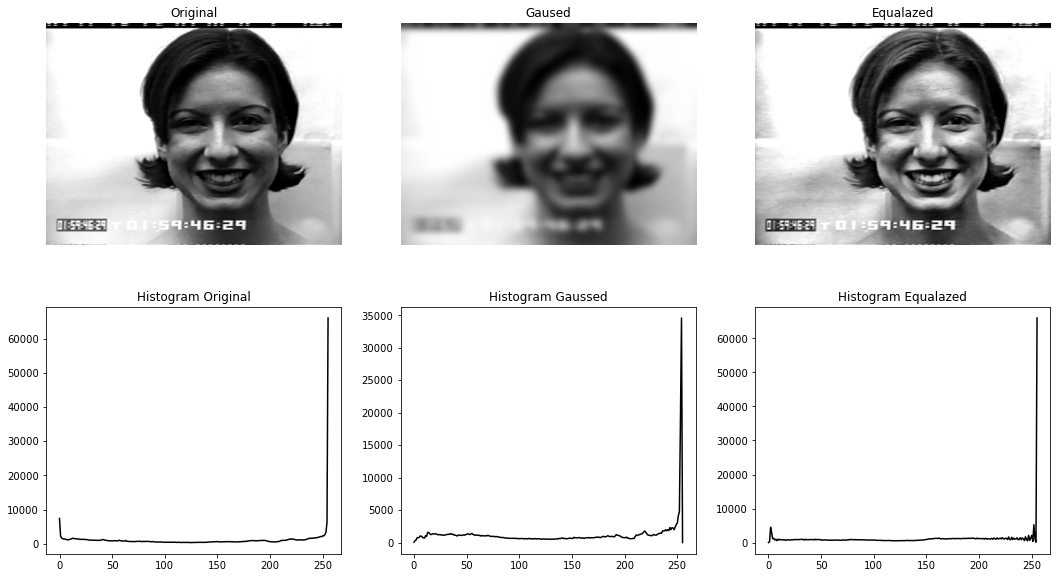

In [12]:
img_files_list = allFiles
image_1 = cv2.imread(img_files_list[10])
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY); 
image_GF_1 = gaussian_filter(image_1, 7)
# эквализация гистограммы
clahe_1 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) 
image_CLAHE_1 = clahe_1.apply(image_1)
plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1)
plt.imshow(image_1, cmap='gray')
plt.title('Original')
plt.axis('off')   
plt.subplot(2, 3, 2)
plt.imshow(image_GF_1, cmap='gray')
plt.title('Gaused')
plt.axis('off')   
plt.subplot(2, 3, 3)
plt.imshow(image_CLAHE_1, cmap='gray')
plt.title('Equalazed')
plt.axis('off')
plt.subplot(2, 3, 4)
plt.title("Histogram Original")
hist_1 = cv2.calcHist([image_1], [0],
                      None, [256], [0, 256])
plt.plot(hist_1, color='black')
plt.subplot(2, 3, 5)
plt.title("Histogram Gaussed")
hist_1 = cv2.calcHist([image_GF_1], [0],
                      None, [256], [0, 256])
plt.plot(hist_1, color='black')
plt.subplot(2, 3, 6)
plt.title("Histogram Equalazed")
hist_1 = cv2.calcHist([image_CLAHE_1], [0],
                      None, [256], [0, 256])
plt.plot(hist_1, color='black')
plt.show()

Сделаем функцию предпроцессинга, которая с помощью модуля face_recognition, реализующий детектирование лица на изображениях по гистограмме градиентов, позволит сделать вырезание из исходных фоток лишь область лиц с заданным размером на выходе. В процессе преодобработки применеим фильтрацию гаусса и эквализацию гитограммы исодной фотки для убирания артефактов возможной засветки

То есть на вход подается массив необработанных фоток некого размера а на выходе получается массив фоток размером 64 на 64, состоящий исключительно из вырезанных областей лиц

In [13]:
def ImagePreProcessing(data, sigma_GF, IMG_HEIGHT, IMG_WIDTH):
    X = []
    # При помощи флагов выведу лишь определенные фотки в качестве пояснения к работе кода
    flag = 0
    for image in data:
        image = cv2.imread(image) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY); 

        if flag in [0, 10, 20]:
            plt.figure(figsize=(8, 8))
            plt.subplot(2, 2, 1)
            plt.imshow(image, cmap='gray')
            plt.title('Original')
            plt.subplot(2,2,3)
            plt.title("Histogram Original")
            hist_1 = cv2.calcHist([image], [0],
                                  None, [256], [0, 256])
            plt.plot(hist_1, color='black')

        image_GF = gaussian_filter(image, sigma_GF)
        
        # Face detection + crop
        face_loc = fr.face_locations(img=image_GF, model='hog')
        if len(face_loc)>1:
            face_loc=[(face_loc[0])]

        a = collections.deque(*face_loc)
        a.rotate(1)
        shifted = list(a)
        img = PIL.Image.fromarray(image_GF)
        img2 = img.crop((shifted))
        image_CROPPED = np.array(img2)

        # выполните эквализацию гистограммы с cv2.createCLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image_CLAHE = clahe.apply(image_CROPPED)

        # Scale
        image_SCALED = PIL.Image.fromarray(image_CLAHE).\
            resize((IMG_HEIGHT, IMG_WIDTH))

        X.append(np.array(image_SCALED))
        if flag in [0, 10, 20]:
            plt.subplot(2, 2, 2)
            plt.imshow(image_SCALED, cmap='gray')

            plt.title('Cropped')
            plt.subplot(2, 2, 4)
            plt.title("Histogram Cropped")
            hist_1 = cv2.calcHist([ np.array(image_SCALED)], [0],
                                  None, [256], [0, 256])
            plt.plot(hist_1, color='black')
            plt.show()

        flag = flag + 1  
    X = np.array(X)  
    return X

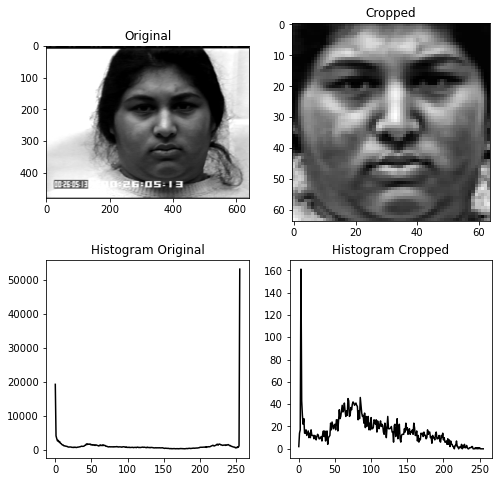

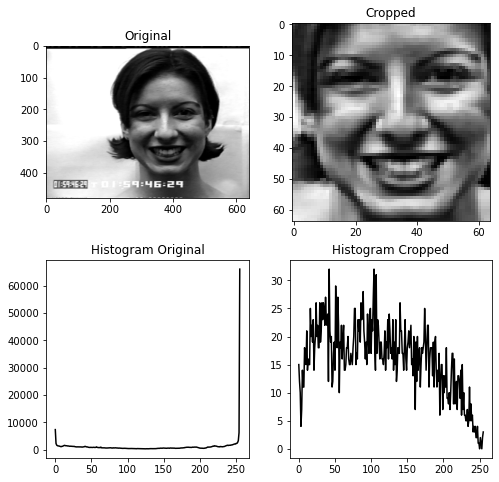

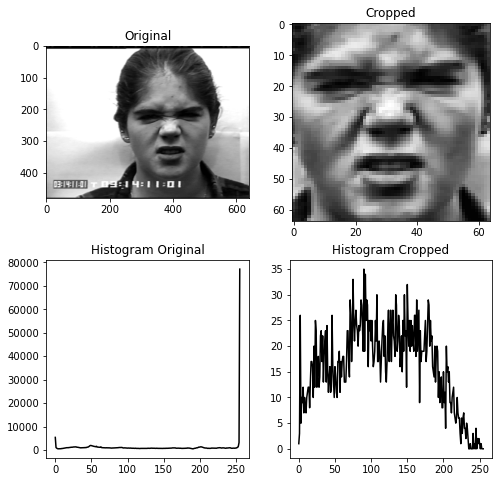

In [14]:
#применение функции для преобработки данных с размером 64 на 64 и выведем
X_processed = ImagePreProcessing(img_files_list, 1, 64, 64)

In [15]:
X_processed.shape

(920, 64, 64)

## Извлечение признаков с фильтрами Габбора

Напишем функцию (GaborFiltersFeatures) для создания 8 фильтров Габора (cv2.getGaborKernel) со следующими параметрами:

In [16]:
theta_range = np.arange(0, np.pi, np.pi/8)  # Фазы синусоиды
lamda = 3*np.pi/4  # Фиксированная частота синусоиды
gamma = 0.5  # Параметр Гаусса
sigma = 0.75  # Параметр Гаусса
ksize = (9,9)
phi = 0 

На выходе для каждой фотки размером 64 на 64 будет получено 8 отфильтрованных изображений с разными фильтрами из банка фильтров Габара. После этого в начале будет добавлено исходное изображение и после операции flattern на выходе мы получим вектор признаков размером 9 (число фоток, полученных из одной) х 64 х 64 (размер исходной фотки фотки после предобработки)

Следовательно каждой из 920 фоток будет соответствовть вектор признаков размера 9 х 64 х 64 = 36864

100%|██████████| 920/920 [00:02<00:00, 385.38it/s]


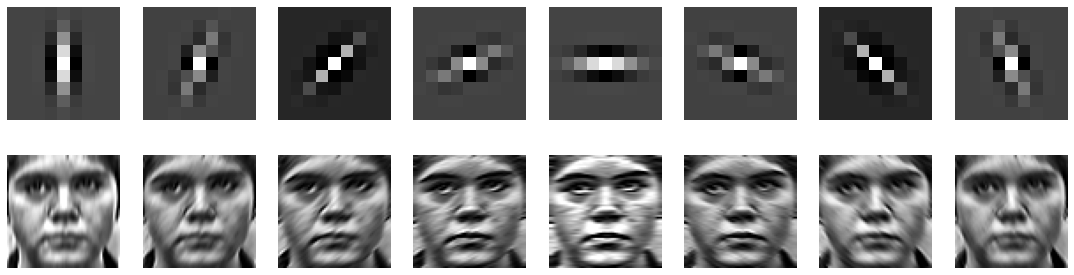

In [17]:
def GaborFiltersFeatures(X_processed, ksize, sigma, theta_range, lambd, gamma, psi):
    result = []
    flag = 0
    final = []
    res = []
    for im in tqdm(X_processed):
        final = np.asarray(im.flatten())
        for i in range(0, theta_range.size):
            g_kernel = cv2.getGaborKernel(ksize, sigma, theta_range[i],
                                          lambd, gamma, psi, ktype=cv2.CV_32F)
            if flag == 0:
                plt.subplot(2, theta_range.size, i + 1)
                plt.imshow(g_kernel, cmap='gray')
                plt.axis('off') 
            filtered_img = cv2.filter2D(im, cv2.CV_8UC3, g_kernel)
            if flag == 15:
                plt.subplot(2, theta_range.size, 8 + i +1)
                plt.imshow(filtered_img, cmap='gray')
                plt.axis('off') 
            features = filtered_img.flatten()
            final = np.concatenate((final, features), axis=None)
      
        res.append(final)
        flag = flag + 1 
    return np.asarray(res)


fig, axes = plt.subplots(2, 7, figsize=(19, 5))
X_features = GaborFiltersFeatures(X_processed, ksize, sigma, theta_range, lamda, gamma, phi)


In [18]:
X_features.shape

(920, 36864)

Вот, как выглядит исзодный массив данных перед стадиями разделения выборки на тренировочную и тестовую

In [19]:
data_features = pd.DataFrame(data=X_features,
          index=pd.RangeIndex(range(0, 920)),
          columns=pd.RangeIndex(range(0, 36864)))
data_features

,0,1,2,3,4,5,6,7,8,9,...,36854,36855,36856,36857,36858,36859,36860,36861,36862,36863
0,30,28,20,9,6,3,3,3,3,6,...,35,56,52,27,26,58,46,32,105,135
1,26,24,20,18,10,4,3,4,3,3,...,37,59,57,33,27,53,40,31,105,134
2,36,41,26,17,21,25,23,48,63,46,...,56,63,72,72,69,81,110,170,187,178
3,41,37,17,8,13,21,26,50,53,34,...,55,71,78,76,77,98,134,179,179,173
4,35,46,29,16,13,16,16,36,63,52,...,30,44,57,74,81,94,123,170,181,174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,124,118,96,59,58,64,75,83,84,67,...,43,43,46,73,61,76,100,81,116,41
916,106,89,76,99,105,106,54,67,67,90,...,109,125,139,107,25,4,30,31,102,139
917,146,114,111,101,98,106,93,48,55,80,...,150,155,142,120,82,28,21,72,95,38
918,116,136,140,106,92,57,57,91,70,60,...,95,147,135,107,30,6,18,34,52,153


Очевидно, что размер вектора признаков состоит из 36863 признаков. Данное число признаков слишком большое для обучения моделей, поэтому воспользуемся снижением размерности с помощью PCA (МГК)

Но перед процедурой снижения размерности необходимо сначала отделить тренировочную и тестовую выборки. Инач емы при поиске проекций с максимальными дисперсиями будем учитывать данные, которые машина знать не должна, ведь они отнесены к тестовой выборке

Разобьем данные на train и test:

## Задание метки класса 

In [442]:
df.head()

,label,file name
0,1,S010_004_00000019.png
1,1,S011_004_00000021.png
2,1,S014_003_00000030.png
3,1,S022_005_00000032.png
4,1,S026_003_00000015.png


In [443]:
data_features['file name'] = list_im

In [444]:
data_features.head()

,0,1,2,3,4,5,6,7,8,9,...,36855,36856,36857,36858,36859,36860,36861,36862,36863,file name
0,30,28,20,9,6,3,3,3,3,6,...,56,52,27,26,58,46,32,105,135,S005_001_00000001.png
1,26,24,20,18,10,4,3,4,3,3,...,59,57,33,27,53,40,31,105,134,S005_001_00000011.png
2,36,41,26,17,21,25,23,48,63,46,...,63,72,72,69,81,110,170,187,178,S010_001_00000001.png
3,41,37,17,8,13,21,26,50,53,34,...,71,78,76,77,98,134,179,179,173,S010_002_00000001.png
4,35,46,29,16,13,16,16,36,63,52,...,44,57,74,81,94,123,170,181,174,S010_002_00000014.png


Объединим таблицы чтоб определить метку класса

In [445]:
data_full = data_features.merge(df, how='left', on='file name')

In [446]:
data_full.head()

,0,1,2,3,4,5,6,7,8,9,...,36856,36857,36858,36859,36860,36861,36862,36863,file name,label
0,30,28,20,9,6,3,3,3,3,6,...,52,27,26,58,46,32,105,135,S005_001_00000001.png,0
1,26,24,20,18,10,4,3,4,3,3,...,57,33,27,53,40,31,105,134,S005_001_00000011.png,3
2,36,41,26,17,21,25,23,48,63,46,...,72,72,69,81,110,170,187,178,S010_001_00000001.png,0
3,41,37,17,8,13,21,26,50,53,34,...,78,76,77,98,134,179,179,173,S010_002_00000001.png,0
4,35,46,29,16,13,16,16,36,63,52,...,57,74,81,94,123,170,181,174,S010_002_00000014.png,6


Посмотрм число фоток кадого класса:

In [447]:
data_full.label.value_counts()

0    621
6     83
5     69
3     59
1     45
4     25
2     18
Name: label, dtype: int64

In [448]:
data_full.head()

,0,1,2,3,4,5,6,7,8,9,...,36856,36857,36858,36859,36860,36861,36862,36863,file name,label
0,30,28,20,9,6,3,3,3,3,6,...,52,27,26,58,46,32,105,135,S005_001_00000001.png,0
1,26,24,20,18,10,4,3,4,3,3,...,57,33,27,53,40,31,105,134,S005_001_00000011.png,3
2,36,41,26,17,21,25,23,48,63,46,...,72,72,69,81,110,170,187,178,S010_001_00000001.png,0
3,41,37,17,8,13,21,26,50,53,34,...,78,76,77,98,134,179,179,173,S010_002_00000001.png,0
4,35,46,29,16,13,16,16,36,63,52,...,57,74,81,94,123,170,181,174,S010_002_00000014.png,6


Выборки слишком неравномерные. Увеличим число элементов иных классов кроме нейтрального в 3 раза. То есть добавим те же элементы еще 2 раза, тем самым искусственно увеличим число данных. Но чтобы не было ошибки надо увеличивать уже после разделения на тест и трейн чтобы не было такого, чтобы случайно при разделении в трейне и тесте оказались одинаковые элементы.

## Разбивка данных на train и test:

In [449]:
y = data_full.label
X = data_full.drop(['file name'], axis=1)

In [450]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [451]:
y_train.value_counts()

0    497
6     67
5     55
3     47
1     36
4     20
2     14
Name: label, dtype: int64

Хоть немного сделаем более равномерное число классов и применим upsampling:

In [452]:
d_add = X_train.query('label != 0')
X_train = X_train.append(d_add, ignore_index=True)
X_train = X_train.append(d_add, ignore_index=True)
X_train = X_train.append(d_add, ignore_index=True)
X_train = X_train.append(d_add, ignore_index=True)
d_add = X_train.query('label in [2,4]')
X_train = X_train.append(d_add, ignore_index=True)
X_train = X_train.append(d_add, ignore_index=True)
X_train.label.value_counts()

0    497
6    335
4    300
5    275
3    235
2    210
1    180
Name: label, dtype: int64

In [453]:
y_train = X_train.label
X_train = X_train.drop(columns=['label'])

In [454]:
y_test.value_counts()

0    124
6     16
5     14
3     12
1      9
4      5
2      4
Name: label, dtype: int64

Хоть немного сделаем более равномерное число классов и применим upsampling:

In [455]:
d_add = X_test.query('label != 0')
X_test = X_test.append(d_add, ignore_index=True)
X_test = X_test.append(d_add, ignore_index=True)
X_test = X_test.append(d_add, ignore_index=True)
X_test = X_test.append(d_add, ignore_index=True)
d_add = X_test.query('label in [2,4]')
X_test = X_test.append(d_add, ignore_index=True)
X_test = X_test.append(d_add, ignore_index=True)
d_add = X_test.query('label in [1]')
X_test = X_test.append(d_add, ignore_index=True)
X_test.label.value_counts()

0    124
1     90
6     80
4     75
5     70
3     60
2     60
Name: label, dtype: int64

In [456]:
y_test = X_test.label
X_test = X_test.drop(columns=['label'])

In [457]:
X_train.shape

(2032, 36864)

In [458]:
X_test.shape

(559, 36864)

In [459]:
X_train = np.array(X_train)

In [460]:
X_test = np.array(X_test)

---

## Применим LDA классификатор без уменьшения размерности данных:

Точность модели на обучающей выборке:  0.99
Точность модели на тестовой выборке:  0.55
Матрица несоответствий метода "Линейный дискриминантный анализ без МГК":



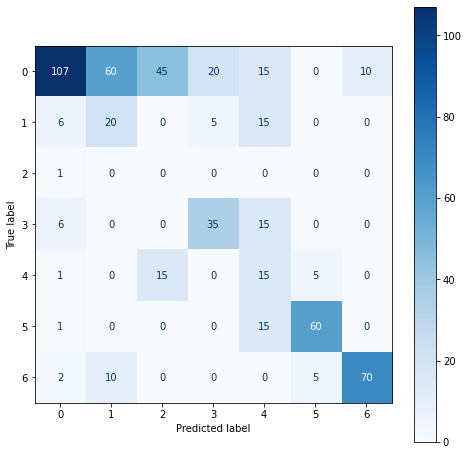

In [204]:
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_train, y_train)
LDA_prediction = LDA_model.predict(X_test)

LDA_train_accuracy = LDA_model.score(X_train, y_train)
LDA_test_accuracy = LDA_model.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (LDA_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (LDA_test_accuracy, 2))

print('Матрица несоответствий метода "Линейный дискриминантный анализ без МГК":\n')

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(LDA_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

In [205]:
print ('\n clasification report:\n', classification_report(y_test, LDA_model.predict(X_test)))


 clasification report:
               precision    recall  f1-score   support

           0       0.42      0.86      0.56       124
           1       0.43      0.22      0.29        90
           2       0.00      0.00      0.00        60
           3       0.62      0.58      0.60        60
           4       0.42      0.20      0.27        75
           5       0.79      0.86      0.82        70
           6       0.80      0.88      0.84        80

    accuracy                           0.55       559
   macro avg       0.50      0.51      0.48       559
weighted avg       0.50      0.55      0.50       559



__Итог: accuracy = 93%__

---

# Применение снижения размерности (PCA)

In [461]:
# Временно сохраним старые данные в новые переменные 
X_train_no_PCA = X_train.copy()
X_test_no_PCA = X_test.copy()

Напишием код примененеия PCA к исходным данным для снижения размерности признаков (90% дисперсии)

In [462]:
# Шаг 1 - Стандартизация X_train
scaler = StandardScaler()
scaler.fit(X_train)
scaled_data = scaler.transform(X_train)
scaled_data.shape

(2032, 36864)

In [463]:
# Стандартизованные данные
pd.DataFrame(data=scaled_data,
          index=pd.RangeIndex(range(0, scaled_data.shape[0])),
          columns=pd.RangeIndex(range(0, 36864)))

,0,1,2,3,4,5,6,7,8,9,...,36854,36855,36856,36857,36858,36859,36860,36861,36862,36863
0,-0.512623,-0.609478,-0.699608,-0.740134,-0.755057,-0.769175,-0.838583,-0.640556,-0.034134,0.864283,...,0.155967,0.353423,0.384437,0.070108,-0.039392,0.456842,1.373521,1.731026,-0.043461,-1.438548
1,-0.877818,-0.986517,-1.122309,-1.187578,-0.858062,-0.833145,-1.222056,-1.439525,-1.439688,-1.585296,...,-1.677254,-1.337633,-0.860718,-0.890476,-0.527805,-0.996752,-0.517885,0.222214,0.339397,0.854318
2,-0.877818,-0.986517,-1.102180,-1.057074,-0.961066,-0.833145,-0.731211,-0.580257,-0.278579,-0.103067,...,-0.768614,-0.546405,-0.310533,-0.055186,0.197838,0.530256,0.818108,1.124391,1.200829,0.487460
3,-0.828019,-0.741441,-0.256778,0.229328,0.618342,0.654172,0.449886,0.248862,0.042254,-0.165476,...,0.171908,0.353423,0.254130,0.376381,0.323430,0.060407,-0.382785,-1.255488,-0.936797,2.291181
4,-0.745020,-0.816849,-0.860637,-1.094361,-1.167076,-1.264947,-1.191378,-1.017428,-0.828578,-0.711561,...,1.016783,1.579051,-0.513233,-1.516944,-1.169720,-1.143580,-1.418555,-1.504365,-1.495132,-1.392691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027,2.259535,1.596198,1.695697,2.839419,2.146248,0.670165,1.170816,2.253820,1.921419,0.911090,...,1.973246,0.694737,0.268608,0.432067,0.225747,1.308443,1.763812,0.299988,-1.080369,-1.438548
2028,-0.429625,-0.138179,0.427594,0.844564,1.219204,1.373842,1.140138,0.836782,0.745031,0.614644,...,-1.310610,-1.073890,-1.092375,-1.154985,-0.081256,0.251283,0.352762,0.968843,0.100111,-0.353258
2029,1.313349,1.690458,2.118398,2.242827,2.232085,1.885608,1.400900,1.108130,1.218642,1.301151,...,1.224017,1.191194,1.354499,1.476180,1.649124,0.823911,-0.592941,-1.084386,-0.426319,0.059458
2030,0.400363,0.804417,1.333382,0.415763,-0.463209,0.142407,-0.179009,-0.082786,-0.477189,-0.274693,...,-0.146913,-1.399690,-1.106853,-1.182828,-1.267403,-1.084849,-0.818108,-0.353312,0.371302,1.221177


In [464]:
pca = PCA(n_components=scaled_data.shape[0])
pca.fit(scaled_data)
ratio = pca.explained_variance_ratio_

In [465]:
pca.components_.shape

(2032, 36864)

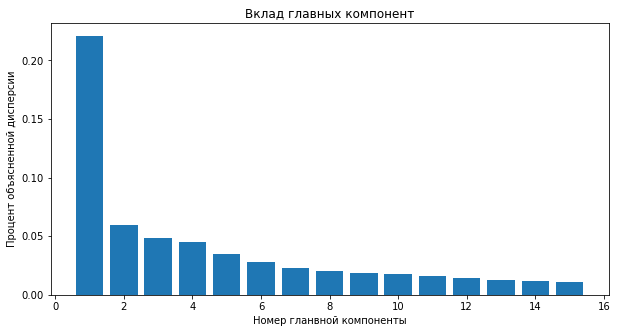

In [466]:
fig = plt.figure(figsize = (10, 5))
plt.xlabel("Номер гланвной компоненты")
plt.ylabel("Процент объясненной дисперсии")
plt.title("Вклад главных компонент")
plt.bar(range(1, 16),ratio[:15])
plt.show()

In [467]:
ss = np.cumsum(ratio)
col = -1
for i in range(len(ss)):
    if float(ss[i]) > 0.9:
        col = i
        break
print('Число главных компонент, объясняющих более 90% дисперсии равно', col+1)

Число главных компонент, объясняющих более 90% дисперсии равно 116


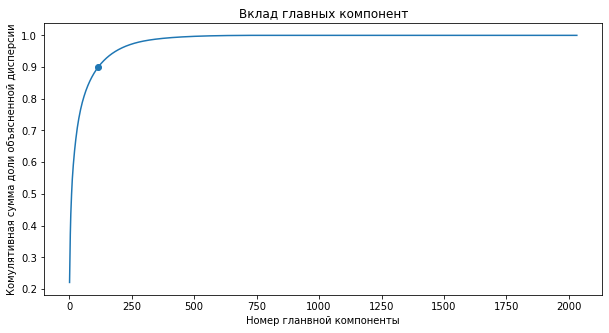

In [468]:
fig = plt.figure(figsize = (10, 5))
plt.xlabel("Номер гланвной компоненты")
plt.ylabel("Комулятивная сумма доли объясненной дисперсии")
plt.title("Вклад главных компонент")
plt.plot(range(1, scaled_data.shape[0]+1), ss[:])
plt.scatter(col, ss[col])
plt.show()

In [469]:
pca = PCA(n_components=col+1)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

In [470]:
x_pca.shape

(2032, 116)

In [471]:
# Итоговые данные 
data_pca = pd.DataFrame(data=x_pca,
          index=pd.RangeIndex(range(0, scaled_data.shape[0])),
          columns=pd.RangeIndex(range(0, col+1)))
X_train = data_pca

In [472]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
0,-227.624452,23.114436,45.998859,30.429224,10.766937,28.579861,-15.364518,67.727508,42.606689,5.488387,...,14.798696,-2.499685,-10.561960,-7.045339,-11.988090,9.170574,3.013181,2.774824,-1.689797,-8.083196
1,79.173780,-50.700727,-36.805734,49.231019,-1.186746,-22.014536,14.515313,-12.539149,21.923205,-6.691319,...,-8.705012,2.577868,10.209406,-7.727766,2.913083,-7.042295,0.889421,-2.898908,3.268386,-7.134964
2,66.541151,-22.007590,9.191453,-64.862172,-15.026559,18.673351,-19.001203,39.375727,-2.815390,24.560810,...,1.877436,-4.299011,-7.039255,0.613479,-0.286574,-6.739499,0.542982,2.085152,-1.423430,5.378897
3,89.986078,57.462595,-18.866503,42.295773,-5.215643,11.678576,-19.067189,29.713431,36.130609,-37.808531,...,-5.715295,-4.704898,1.990218,13.533275,4.085548,-4.735775,1.650974,-8.248758,-2.003846,-3.749783
4,-0.779165,-37.875034,55.938902,-32.872510,-63.380924,-8.965753,2.447920,25.599496,2.389311,10.859616,...,1.603873,8.946189,-1.031476,-7.081917,-3.725180,0.982444,-0.007442,4.195274,-3.589646,4.105844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027,-143.790417,50.883213,29.373589,42.158512,74.770220,44.116099,-53.567054,-0.391163,34.308352,-42.632978,...,5.705171,-3.847420,-0.377579,1.462214,-3.596006,-1.278195,4.329614,0.781183,-0.092432,3.907760
2028,-72.298424,38.536187,35.149086,-16.202065,-60.077073,-74.178639,31.938201,14.717646,-20.793295,-8.801487,...,8.769900,-3.034461,-0.132447,1.841507,4.340256,0.242307,8.448501,-0.745156,4.422961,2.537134
2029,-74.603723,-19.186921,-71.709986,0.140715,-1.011537,-28.882427,3.888550,-52.770542,62.954027,-3.100046,...,11.044080,-3.144825,-0.496771,0.174189,-7.063924,-5.186575,-3.044987,-0.848291,1.694081,-0.865291
2030,-63.172995,27.856550,0.569857,32.243568,-45.959561,-11.269658,2.697485,20.740886,-14.669913,-63.644360,...,-3.587157,6.942538,-6.494490,-2.457707,2.659121,-7.983095,-3.955801,1.216285,2.916785,-7.838773


Получим новый X_test как проекцию данных прошлого X_test на собственные вектора, полученные при МГК для X_train

In [473]:
# Шаг 1 - Стандартизация X_test
scaler = StandardScaler()
scaler.fit(X_test)
scaled_data = scaler.transform(X_test)
scaled_data.shape

(559, 36864)

In [474]:
# Стандартизованные данные
pd.DataFrame(data=scaled_data,
          index=pd.RangeIndex(range(0, scaled_data.shape[0])),
          columns=pd.RangeIndex(range(0, 36864)))

,0,1,2,3,4,5,6,7,8,9,...,36854,36855,36856,36857,36858,36859,36860,36861,36862,36863
0,-0.841644,-0.961072,-1.002011,-1.065813,-0.997618,-0.803105,-0.912318,-1.291999,-1.398600,-1.431351,...,-2.150495,-1.740591,-1.423093,-1.304987,-0.966324,-1.144233,-0.790282,-0.069804,0.217963,0.684992
1,-0.819150,-0.546253,0.179316,0.654822,0.824154,1.049860,1.153785,0.976068,0.800059,0.694434,...,1.782163,-0.042253,-1.752366,-1.140503,-0.341811,-0.737555,-0.520728,0.044482,0.217963,0.132766
2,1.835240,2.235473,2.301331,2.551431,2.285010,1.756499,1.257834,0.990514,1.029984,1.014758,...,1.098947,1.310127,1.524688,1.521152,1.560777,0.560686,-0.996412,-0.935110,-0.446712,-0.157879
3,-0.841644,-0.961072,-1.002011,-1.046260,-1.031991,-0.426231,0.351127,0.614910,0.627615,0.621634,...,0.149110,-0.183781,-1.062460,-0.826488,-0.632282,-0.596782,-0.441447,-0.526947,-0.573316,-0.564782
4,0.260602,0.063775,-0.258212,-0.596549,-0.619515,-0.520449,-0.555580,-0.540792,-0.349566,-0.135496,...,0.199101,0.964169,-0.466632,-1.678816,-0.588711,-0.143180,0.541633,1.366930,1.389055,1.382540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,-0.346758,-0.375445,-0.476977,-0.537891,-0.602328,-0.489043,-0.362348,-0.367437,-0.277715,-0.179176,...,0.699015,1.058522,0.505509,-0.796581,-1.155130,-1.316289,-1.408672,-1.539191,-1.348770,-1.204201
555,-0.684181,-0.717061,-0.783247,-0.948497,-0.997618,-0.614668,-0.109659,0.037059,-0.507640,-1.038226,...,1.365567,-0.592640,-1.768046,-1.349847,-0.777518,-0.925253,-0.885419,-0.886130,-0.905653,-0.608379
556,-0.706676,-0.155835,0.682474,1.495587,1.700668,1.520953,1.421338,1.221655,1.073095,0.869156,...,-0.334141,-0.246683,0.019438,0.833309,1.386494,2.093550,0.018381,-1.457558,-1.048084,-0.971685
557,0.395571,-0.277841,-0.717618,-0.889839,-0.636701,-0.693184,-0.510988,-0.295206,-0.205863,-0.091815,...,-0.867382,-0.828521,-0.968382,-1.334894,-0.864659,-0.205745,-0.060900,0.354686,1.246625,0.757653


In [475]:
x_pca = pca.transform(scaled_data)
x_pca.shape

(559, 116)

In [476]:
# Итоговые данные 
data_pca = pd.DataFrame(data=x_pca,
          index=pd.RangeIndex(range(0, scaled_data.shape[0])),
          columns=pd.RangeIndex(range(0, col+1)))
X_test = data_pca
X_test

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
0,86.666541,-58.040316,-32.480864,60.783152,7.084201,-45.151191,-0.886952,29.678363,22.649781,2.096266,...,-1.046349,-4.624668,11.914252,-2.249966,8.685953,-8.363361,13.050123,-2.035401,-0.701827,-3.553227
1,-6.647847,11.465784,-42.549133,95.721961,1.530222,-24.388021,-28.418619,17.118630,32.247297,-21.496937,...,-6.917629,-0.985473,5.551020,7.425230,3.812444,4.160214,-11.065195,4.066103,-7.946923,-2.724392
2,-51.670016,-38.364888,-80.636142,-16.828268,42.963965,-31.659939,-31.839509,-23.427929,45.069530,5.740882,...,-13.601041,0.391056,5.753030,3.774305,6.812536,-7.123961,-3.590038,3.748233,-0.208354,-3.424251
3,61.368740,22.812428,-55.704439,5.983971,-26.018790,23.863386,-5.944421,31.749691,28.318036,-12.114937,...,5.505619,-2.669773,-9.234622,-3.494941,2.583233,-5.200884,0.350458,1.371580,-11.274806,5.990974
4,86.633581,75.711730,-28.326937,-25.348964,65.733410,11.804103,26.809973,37.170359,-43.357841,-30.784343,...,0.948896,-2.328353,-6.304309,5.075185,-3.449991,-2.478765,-1.805214,-0.988959,0.464502,-1.149478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,142.421477,-62.423106,-41.640600,-26.702455,-17.814665,38.906038,-41.529441,-22.118340,-24.131963,38.529375,...,0.992306,-9.152005,9.498956,-7.086603,-4.681059,-3.403392,10.291477,-2.673468,-5.469002,-15.438386
555,69.354526,20.880512,-28.005964,-9.321754,-16.877462,60.650531,11.675073,26.392656,1.929899,-28.075136,...,-12.770188,-9.811784,8.251683,1.843368,-3.267764,-0.885733,2.330528,-1.514074,-2.168376,1.908290
556,-28.675672,38.815311,12.266821,-28.127602,-41.690391,-36.029557,-3.365189,-21.055385,-5.172927,-9.023398,...,-1.994459,1.240386,-2.688699,-0.391098,-1.534427,-2.191711,3.735122,3.284968,-1.448197,-4.701598
557,67.271133,-21.117625,73.969430,11.079330,4.647108,-34.209092,-2.534805,18.665645,5.041265,0.717906,...,2.559862,-3.666465,-0.731124,-9.175337,0.311173,1.283706,0.516120,1.429801,-0.021286,9.952168


In [477]:
X_train.shape

(2032, 116)

In [478]:
X_test.shape

(559, 116)

# ML (Машинное обучение после снижения размерности данных c помощью МГК)

Загрузим необходимые библиотеки для машинного обучения

In [224]:
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import random
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB  
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
random.seed(17)

In [225]:
# Импортируем модули, необходимые для визуализации дерева решений.
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML

Для оценки качества предсказания будем использовать метрику accuracy так как нет предпочтения какой-то конкретной эмоции в процессе классификации

## Классификатор Tree

In [479]:
# Зададим диапазон исследуемых значений.
max_depth_values = range(1, 51)
scores_iris_data = pd.DataFrame()
rs = np.random.seed(17)
scores_data=pd.DataFrame()

for max_depth in max_depth_values:
    # Изменяем глубину обучения дерева по циклу от 1 до 50 с шагом 1.
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=rs)
    # Обучаем дерево решений (с ограниченной глубиной) на подмножестве train.
    clf.fit(X_train, y_train)
    # Записываем в отдельную переменную число правильных ответов на обученной модели дерева
    train_score = clf.score(X_train, y_train)
    No_validation_score = clf.score(X_test, y_test)
    # Записываем в отдельную переменную число правильных ответов на обученной модели дерева
    test_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    # Создаем временный DataFrame.
    temp_score_data = pd.DataFrame({'max_depth':[max_depth],
                                    'Train_score':[train_score],
                                    'Test_score':[No_validation_score],  
                                    'Validation_score':[test_val_score]})
    # Наращиваем DataFrame "scores_iris_data".
    scores_data = scores_data.append(temp_score_data)
scores_data.head(10)

,max_depth,Train_score,Test_score,Validation_score
0,1,0.308071,0.252236,0.291816
0,2,0.362697,0.277281,0.353834
0,3,0.425197,0.329159,0.429139
0,4,0.505906,0.275492,0.504921
0,5,0.622539,0.271914,0.616639
0,6,0.771654,0.221825,0.739184
0,7,0.878445,0.211091,0.839075
0,8,0.959646,0.277281,0.900096
0,9,0.993602,0.254025,0.940939
0,10,0.999016,0.273703,0.946353


Обратим внимание, что кросс-валидация будет менее информативна так как данные будут валидироваться из трейновой выборки, которая и является той, на которой мы МГК обучали. Тестовая не участвовала в обучении МГК (PCA) так что там не будет никаких подгонов при расчете

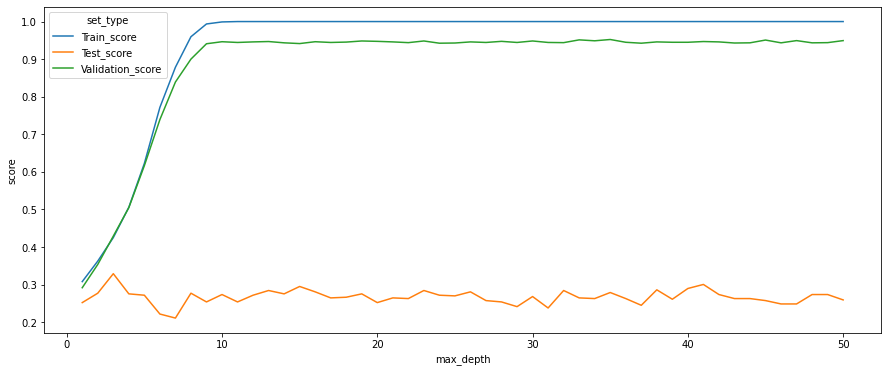

In [480]:
fig = plt.figure(figsize = (15, 6))
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'],
                           value_vars=['Train_score','Test_score','Validation_score'],
                           var_name='set_type', value_name='score')
sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long);

Такой большой разброс accuracy по тестовой и валидационной выборки вызван тем, что мы делали upsampling и при кросс-валидации используется train выборка. Тем самым часто при CV возникает пересечение и повторение данных, что приводит к псевдо-хорошим результатам. На тесте как раз такого не происходит, ведь выборки никак не пересекаются. 
Далее мы будем проводить GridSearchCV для поиска наилучших параметров так что стоит учитывать, этот выше описанный факт чтобы итоговая модельимела более высокую предсказательную способность

In [482]:
#Подбор лучших параметров:
par = {'max_depth':range(3, 6), 'min_samples_split':range(2, 6),
     'min_samples_leaf':range(2, 6)}
search = GridSearchCV(clf,par,cv=5)
search.fit(X_train, y_train)
search.best_params_

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 3}

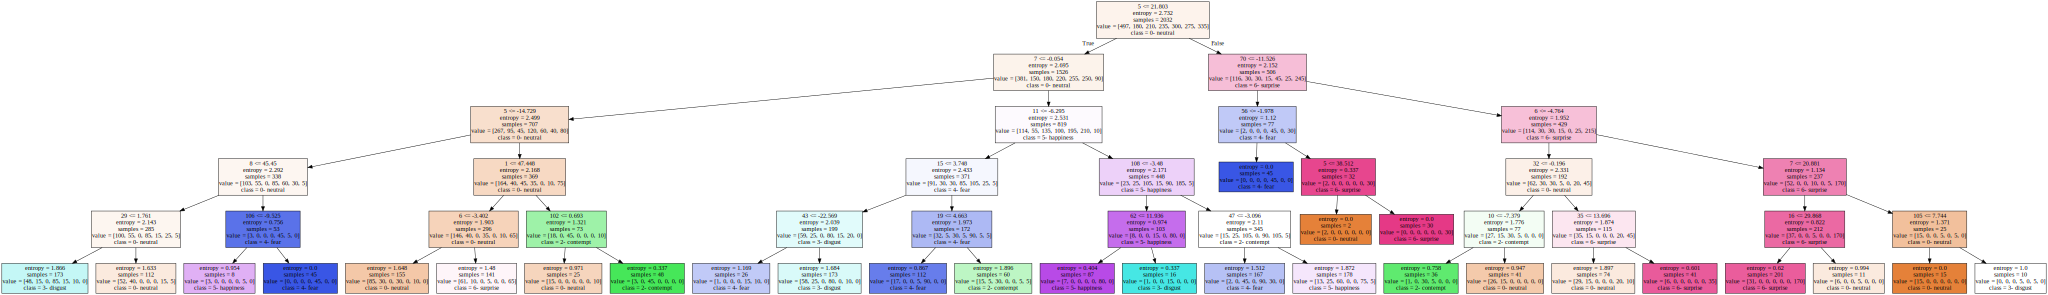

In [483]:
best_tree=search.best_estimator_
clf_best=best_tree
graph=Source(tree.export_graphviz(best_tree, out_file=None
                                  , feature_names=list(X_train)
                                  , class_names=['0- neutral', '1- anger', '2- contempt', '3- disgust',
         '4- fear', '5- happiness', '6- surprise']
                                  , filled=True)) 
display(SVG(graph.pipe(format='svg')))

In [487]:
train_accuracy = clf_best.score(X_train, y_train)
test_accuracy = clf_best.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (test_accuracy, 2))

Точность модели на обучающей выборке:  0.62
Точность модели на тестовой выборке:  0.26


Матрица несоответствий метода "Дерево решений":



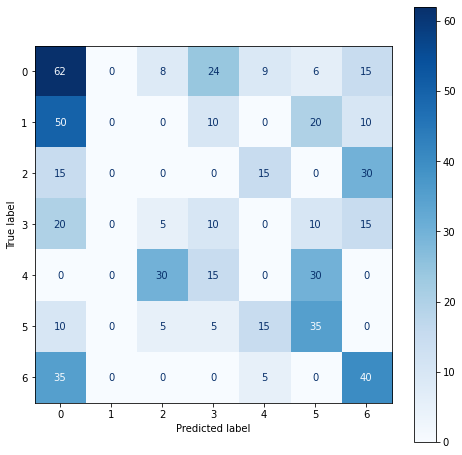

In [488]:
print('Матрица несоответствий метода "Дерево решений":\n')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, clf_best.predict(X_test)))
disp.plot(cmap = 'Blues', ax=ax);

In [490]:
print ('\n clasification report:\n', classification_report(y_test, clf_best.predict(X_test),zero_division=0))


 clasification report:
               precision    recall  f1-score   support

           0       0.32      0.50      0.39       124
           1       0.00      0.00      0.00        90
           2       0.00      0.00      0.00        60
           3       0.16      0.17      0.16        60
           4       0.00      0.00      0.00        75
           5       0.35      0.50      0.41        70
           6       0.36      0.50      0.42        80

    accuracy                           0.26       559
   macro avg       0.17      0.24      0.20       559
weighted avg       0.18      0.26      0.22       559



__Итог: accuracy = 26%__

## Random Forest

Основная идея бэггинга заключается в том, чтобы обучить несколько одинаковых моделей на разных образцах. Распределение выборки неизвестно, поэтому модели получатся разными.
Рандомный лес - бэггинг на деревьях

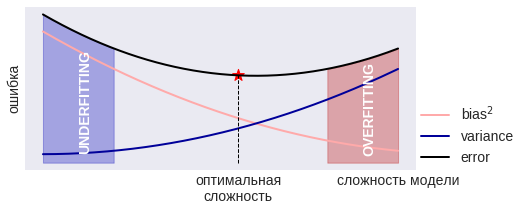

Бэггинг позволяет снизить дисперсию (variance) обучаемого классификатора, уменьшая величину, на сколько ошибка будет отличаться, если обучать модель на разных наборах данных, или другими словами, предотвращает переобучение. Эффективность бэггинга достигается благодаря тому, что базовые алгоритмы, обученные по различным подвыборкам, получаются достаточно различными, и их ошибки взаимно компенсируются при голосовании, а также за счёт того, что объекты-выбросы могут не попадать в некоторые обучающие подвыборки.

In [491]:
clf = RandomForestClassifier(random_state=17)
par = {'n_estimators': range(13, 15), 'max_depth' : range(3, 5)}
search = GridSearchCV(clf, par, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

{'max_depth': 4, 'n_estimators': 13}

In [492]:
clf_best_rf = search.best_estimator_
clf_best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=13, random_state=17)

In [493]:
train_accuracy_rf = clf_best_rf.score(X_train, y_train)
test_accuracy_rf = clf_best_rf.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (train_accuracy_rf, 2))
print ('Точность модели на тестовой выборке: ', round (test_accuracy_rf, 2))

Точность модели на обучающей выборке:  0.69
Точность модели на тестовой выборке:  0.31


Матрица несоответствий метода "Случайный лес":



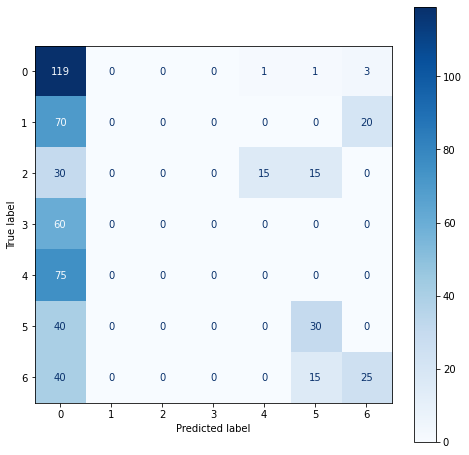

In [494]:
print('Матрица несоответствий метода "Случайный лес":\n')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, clf_best_rf.predict(X_test)))
disp.plot(cmap = 'Blues', ax=ax);

In [495]:
print ('\n clasification report:\n', classification_report(y_test, clf_best_rf.predict(X_test), zero_division=0))


 clasification report:
               precision    recall  f1-score   support

           0       0.27      0.96      0.43       124
           1       0.00      0.00      0.00        90
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00        60
           4       0.00      0.00      0.00        75
           5       0.49      0.43      0.46        70
           6       0.52      0.31      0.39        80

    accuracy                           0.31       559
   macro avg       0.18      0.24      0.18       559
weighted avg       0.20      0.31      0.21       559



__Итог: accuracy = 31%__

## LDA

Точность модели на обучающей выборке:  0.93
Точность модели на тестовой выборке:  0.63
Матрица несоответствий метода "Линейный дискриминантный анализ":



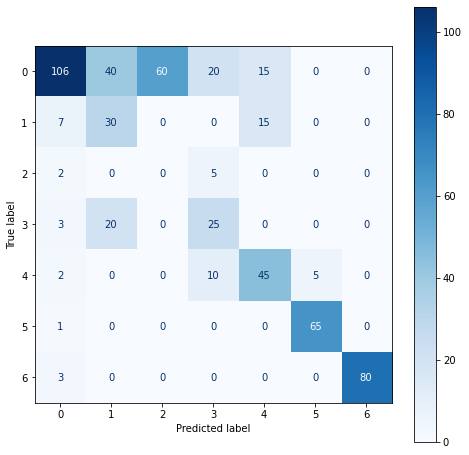

In [238]:
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_train, y_train)
LDA_prediction = LDA_model.predict(X_test)

LDA_train_accuracy = LDA_model.score(X_train, y_train)
LDA_test_accuracy = LDA_model.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (LDA_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (LDA_test_accuracy, 2))

print('Матрица несоответствий метода "Линейный дискриминантный анализ":\n')

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(LDA_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

In [239]:
print ('\n clasification report:\n', classification_report(y_test, LDA_model.predict(X_test)))


 clasification report:
               precision    recall  f1-score   support

           0       0.44      0.85      0.58       124
           1       0.58      0.33      0.42        90
           2       0.00      0.00      0.00        60
           3       0.52      0.42      0.46        60
           4       0.73      0.60      0.66        75
           5       0.98      0.93      0.96        70
           6       0.96      1.00      0.98        80

    accuracy                           0.63       559
   macro avg       0.60      0.59      0.58       559
weighted avg       0.61      0.63      0.59       559



__Итог: accuracy = 63%__

## Бустинг:

Используя различные аппроксимации для пороговой функции потерь $[z < 0]$, будем получать различные виды бустинга. Пример:
- $e^{-z}$ - AdaBoost

Сделаем __AdaBoost__ для деревьев (пеньков скорее так как желательно использовать недообучающиеся модели)

## Метод адаптивного бустинга:

In [240]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,
                                                min_samples_split=20, min_samples_leaf=5), 
                         algorithm="SAMME",n_estimators=100, learning_rate=0.8)
bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=5,
                                                         min_samples_split=20),
                   learning_rate=0.8, n_estimators=100)

In [241]:
print ('\n clasification report:\n', classification_report(y_test, bdt.predict(X_test)))


 clasification report:
               precision    recall  f1-score   support

           0       0.25      0.94      0.39       124
           1       0.00      0.00      0.00        90
           2       0.00      0.00      0.00        60
           3       0.36      0.17      0.23        60
           4       0.00      0.00      0.00        75
           5       1.00      0.21      0.35        70
           6       0.95      0.44      0.60        80

    accuracy                           0.31       559
   macro avg       0.36      0.25      0.22       559
weighted avg       0.35      0.31      0.24       559



Найдем лучшие параметры вариируя параетры бустинга:

In [242]:
'''
bdt = AdaBoostClassifier(DecisionTreeClassifier(random_state=17, max_depth=2,
                                                min_samples_split=20, min_samples_leaf=5))
par = {'n_estimators': range(100, 700, 100), 
     'learning_rate': [x / 10.0 for x in range(7, 10, 2)] }
search = GridSearchCV(bdt, par, cv=4, n_jobs=-1)
search.fit(X_train, y_train)
print('search.best_params_')
bdt_best = search.best_estimator_
bdt_best.fit(X_train, y_train)
'''

"\nbdt = AdaBoostClassifier(DecisionTreeClassifier(random_state=17, max_depth=2,\n                                                min_samples_split=20, min_samples_leaf=5))\npar = {'n_estimators': range(100, 700, 100), \n     'learning_rate': [x / 10.0 for x in range(7, 10, 2)] }\nsearch = GridSearchCV(bdt, par, cv=4, n_jobs=-1)\nsearch.fit(X_train, y_train)\nprint('search.best_params_')\nbdt_best = search.best_estimator_\nbdt_best.fit(X_train, y_train)\n"

Матрица несоответствий метода "AdaBoost":



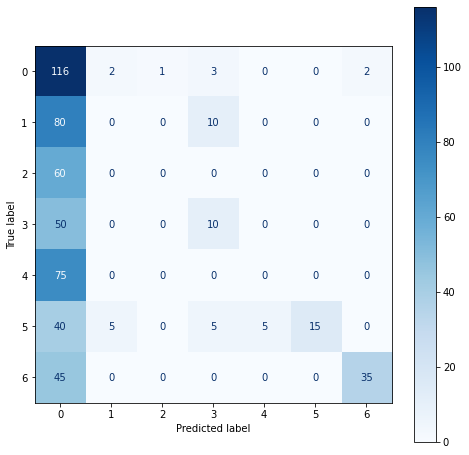

In [245]:
print('Матрица несоответствий метода "AdaBoost":\n')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, bdt.predict(X_test)))
disp.plot(cmap = 'Blues', ax=ax);

__Итог: accuracy = 31%__

## Метод Градиентного бустинга:

Подберем наилучший параметр learning rate:

In [246]:
# get the dataset
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
    return X, y
 
# get a list of models to evaluate
def get_models():
    models = dict()
    # define learning rates to explore
    for i in [0.01, 0.1, 0.5]:
        key = '%.4f' % i
        models[key] = GradientBoostingClassifier(learning_rate=i)
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y_train, scoring='accuracy', cv=10, n_jobs=-1)
    return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)

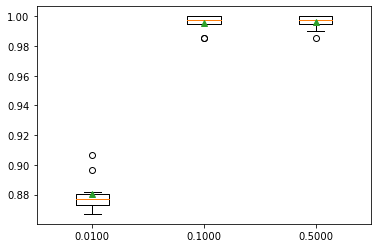

In [247]:
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

0.1 показал выше параметр accuracy

In [248]:
# define the model with default hyperparameters
model = GradientBoostingClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [30, 50, 100]
grid['learning_rate'] = [0.1]
grid['max_depth'] = [2, 3, 4]
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid,
                           n_jobs=-1, cv=10, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.997537 using {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.946849 (0.006547) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 30}
0.976869 (0.005422) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
0.990652 (0.005588) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
0.984744 (0.004094) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 30}
0.994096 (0.005302) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0.995079 (0.005396) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.992616 (0.004544) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 30}
0.995079 (0.004406) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}
0.997537 (0.003972) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


Матрица несоответствий метода "Градиентный бустинг":



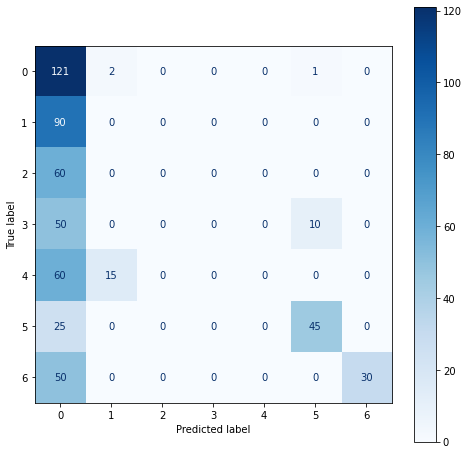

In [249]:
print('Матрица несоответствий метода "Градиентный бустинг":\n')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, grid_result.predict(X_test)))
disp.plot(cmap = 'Blues', ax=ax);

__Итог: accuracy = 35%__

## Логистическая регрессия

Точность модели на обучающей выборке:  0.97
Точность модели на тестовой выборке:  0.6
Матрица несоответствий метода "Логистическая регрессия":



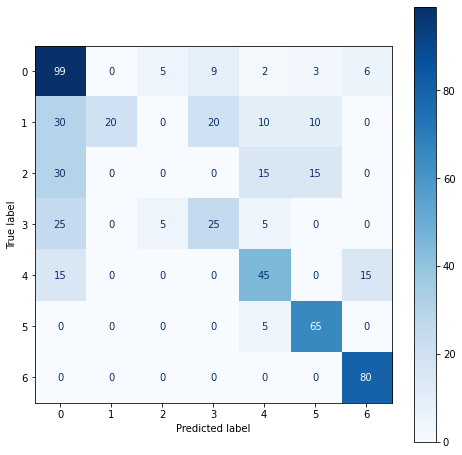

In [261]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(solver='liblinear')
# Обучим модель на обучающей выборке
LR_model.fit(X_train, y_train) 
# Предскажем класс тестовой выборки
LR_prediction = LR_model.predict(X_test) 

LR_train_accuracy = LR_model.score(X_train, y_train)
LR_test_accuracy = LR_model.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (LR_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (LR_test_accuracy, 2))

print('Матрица несоответствий метода "Логистическая регрессия":\n')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, LR_model.predict(X_test)))
disp.plot(cmap = 'Blues', ax=ax);

In [262]:
print ('\n clasification report:\n', classification_report(y_test, LR_model.predict(X_test)))


 clasification report:
               precision    recall  f1-score   support

           0       0.50      0.80      0.61       124
           1       1.00      0.22      0.36        90
           2       0.00      0.00      0.00        60
           3       0.46      0.42      0.44        60
           4       0.55      0.60      0.57        75
           5       0.70      0.93      0.80        70
           6       0.79      1.00      0.88        80

    accuracy                           0.60       559
   macro avg       0.57      0.57      0.52       559
weighted avg       0.60      0.60      0.54       559



__Итог: accuracy = 60%__

## KNN

Точность модели на обучающей выборке:  1.0
Точность модели на тестовой выборке:  0.25
Матрица несоответствий метода "KNN":



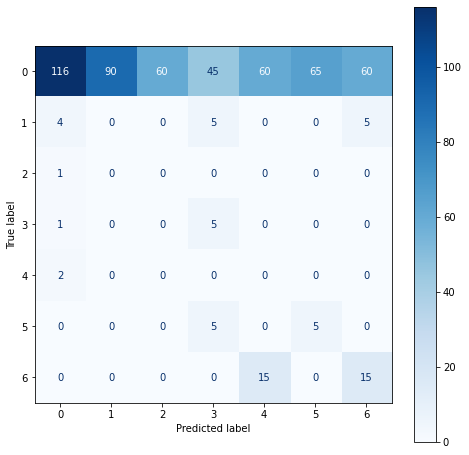

In [503]:
KNN_model = KNeighborsClassifier(n_neighbors = 1)
KNN_model.fit(X_train, y_train)
KNN_prediction = KNN_model.predict(X_test)

KNN_train_accuracy = KNN_model.score(X_train, y_train)
KNN_test_accuracy = KNN_model.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (KNN_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (KNN_test_accuracy, 2))

fig, ax = plt.subplots(figsize=(8, 8))
print('Матрица несоответствий метода "KNN":\n')
disp = ConfusionMatrixDisplay(confusion_matrix(KNN_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

In [498]:
print ('\n clasification report:\n', classification_report(y_test, KNN_prediction, zero_division=0))


 clasification report:
               precision    recall  f1-score   support

           0       0.23      0.94      0.37       124
           1       0.00      0.00      0.00        90
           2       0.00      0.00      0.00        60
           3       0.83      0.08      0.15        60
           4       0.00      0.00      0.00        75
           5       0.50      0.07      0.12        70
           6       0.50      0.19      0.27        80

    accuracy                           0.25       559
   macro avg       0.30      0.18      0.13       559
weighted avg       0.28      0.25      0.15       559



Один из самых низких показателей на тестовой выборке  <br>
__Итог: accuracy = 25%__

## Наивный байесовский алгоритм классификации:

Точность модели на обучающей выборке:  0.9
Точность модели на тестовой выборке:  0.31
Матрица несоответствий метода "Наивный байесовский алгоритм":



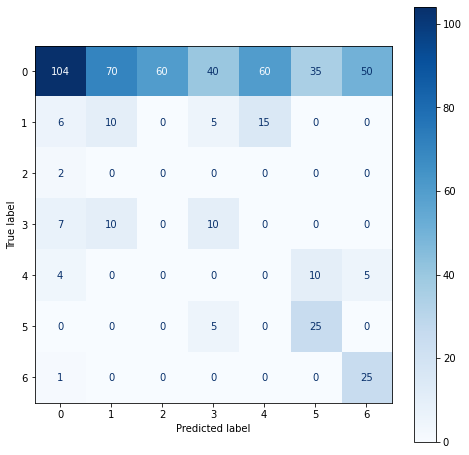

In [266]:
GNB_model = GaussianNB() 
GNB_model.fit(X_train, y_train)
GNB_prediction = GNB_model.predict(X_test) 

GNB_train_accuracy = GNB_model.score(X_train, y_train)
GNB_test_accuracy = GNB_model.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (GNB_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (GNB_test_accuracy, 2))

fig, ax = plt.subplots(figsize=(8, 8))
print('Матрица несоответствий метода "Наивный байесовский алгоритм":\n')
disp = ConfusionMatrixDisplay(confusion_matrix(GNB_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

In [267]:
print ('\n clasification report:\n', classification_report(y_test, GNB_prediction))


 clasification report:
               precision    recall  f1-score   support

           0       0.25      0.84      0.38       124
           1       0.28      0.11      0.16        90
           2       0.00      0.00      0.00        60
           3       0.37      0.17      0.23        60
           4       0.00      0.00      0.00        75
           5       0.83      0.36      0.50        70
           6       0.96      0.31      0.47        80

    accuracy                           0.31       559
   macro avg       0.38      0.26      0.25       559
weighted avg       0.38      0.31      0.27       559



__Итог: accuracy = 31%__

## Метод опорных векторов:

In [268]:
clf = SVC()
par={'degree': range(1,15)}
search=GridSearchCV(clf, par, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

{'degree': 1}

Точность модели на обучающей выборке:  0.94
Точность модели на тестовой выборке:  0.59
Матрица несоответствий метода опорных векторов:



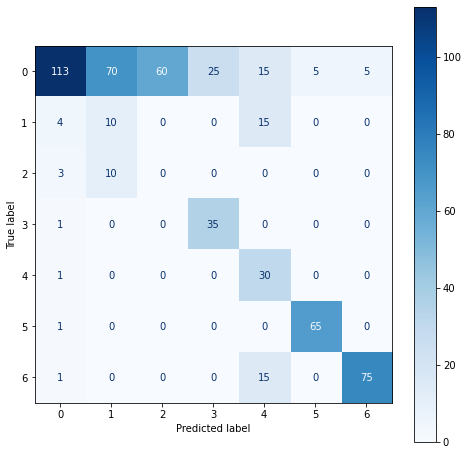

In [269]:
SVC_model = SVC(gamma='scale', kernel='poly', degree=1) 
SVC_model.fit(X_train, y_train)
SVC_prediction = SVC_model.predict(X_test) 

SVC_train_accuracy = SVC_model.score(X_train, y_train)
SVC_test_accuracy = SVC_model.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (SVC_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (SVC_test_accuracy, 2))

fig, ax = plt.subplots(figsize=(8, 8))
print('Матрица несоответствий метода опорных векторов:\n')
disp = ConfusionMatrixDisplay(confusion_matrix(SVC_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

In [270]:
print ('\n clasification report:\n', classification_report(y_test, SVC_prediction))


 clasification report:
               precision    recall  f1-score   support

           0       0.39      0.91      0.54       124
           1       0.34      0.11      0.17        90
           2       0.00      0.00      0.00        60
           3       0.97      0.58      0.73        60
           4       0.97      0.40      0.57        75
           5       0.98      0.93      0.96        70
           6       0.82      0.94      0.88        80

    accuracy                           0.59       559
   macro avg       0.64      0.55      0.55       559
weighted avg       0.62      0.59      0.55       559



__Итог: accuracy = 59%__

**Высокие уровни точности показали: ЛДА после снижения размерности (63%), SVM после снижения размерности (59%), логистическая регрессия после снижения размерности (60%).**

---

# Воспользуемся LDA после PCA для сижения размерности с 138 признаков до числа классов - 1, то есть до 6 признаков

### Проведем те же самые процессы обучения, но на преобразованных по-новому данных:

### Осуществим снижение размерности при использовании LDA:

In [504]:
lda = LinearDiscriminantAnalysis(n_components = 6)
lda_result = lda.fit_transform(X_train, y_train)

In [505]:
lda_result.shape

(2032, 6)

In [506]:
# Итоговые данные 
data_lda = pd.DataFrame(data=lda_result,
          index=pd.RangeIndex(range(0, lda_result.shape[0])),
          columns=pd.RangeIndex(range(0, lda_result.shape[1])))
X_train = data_lda

In [509]:
X_train.head()

,0,1,2,3,4,5
0,-1.974578,-2.109375,0.423680,1.248113,-0.237021,-1.117532
1,0.082186,-0.894036,0.293764,0.783260,0.580203,1.688680
2,-0.527426,-0.538196,2.968738,0.472087,1.143705,-0.399995
3,-1.890434,0.853156,0.622413,0.046594,-1.308740,-0.066332
4,1.379447,-1.506726,1.087909,1.951635,0.845801,0.843903


In [510]:
lda_result = lda.transform(X_test)
lda_result.shape

(559, 6)

In [511]:
# Итоговые данные 
data_lda = pd.DataFrame(data=lda_result,
          index=pd.RangeIndex(range(0, lda_result.shape[0])),
          columns=pd.RangeIndex(range(0, lda_result.shape[1])))
X_test = data_lda

In [512]:
X_test.head()

,0,1,2,3,4,5
0,-4.634088,2.011877,-0.648952,-0.472628,0.263528,0.124827
1,-3.572123,2.705434,-1.451672,-1.089019,0.014124,0.923076
2,-1.565926,1.442323,0.292461,-0.790509,0.431468,0.506549
3,-0.660716,0.039449,0.992124,-0.004451,-1.243534,-0.891688
4,-0.063436,-1.371174,3.180567,-2.089581,-1.371058,-0.462701


# Обучим те же модели:

## Классификатор Tree

In [397]:
#Подбор лучших параметров:
par = {'max_depth':range(3, 7), 'min_samples_split':range(2, 6),
     'min_samples_leaf':range(2, 6)}
search = GridSearchCV(clf,par,cv=5)
search.fit(X_train, y_train)
search.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}

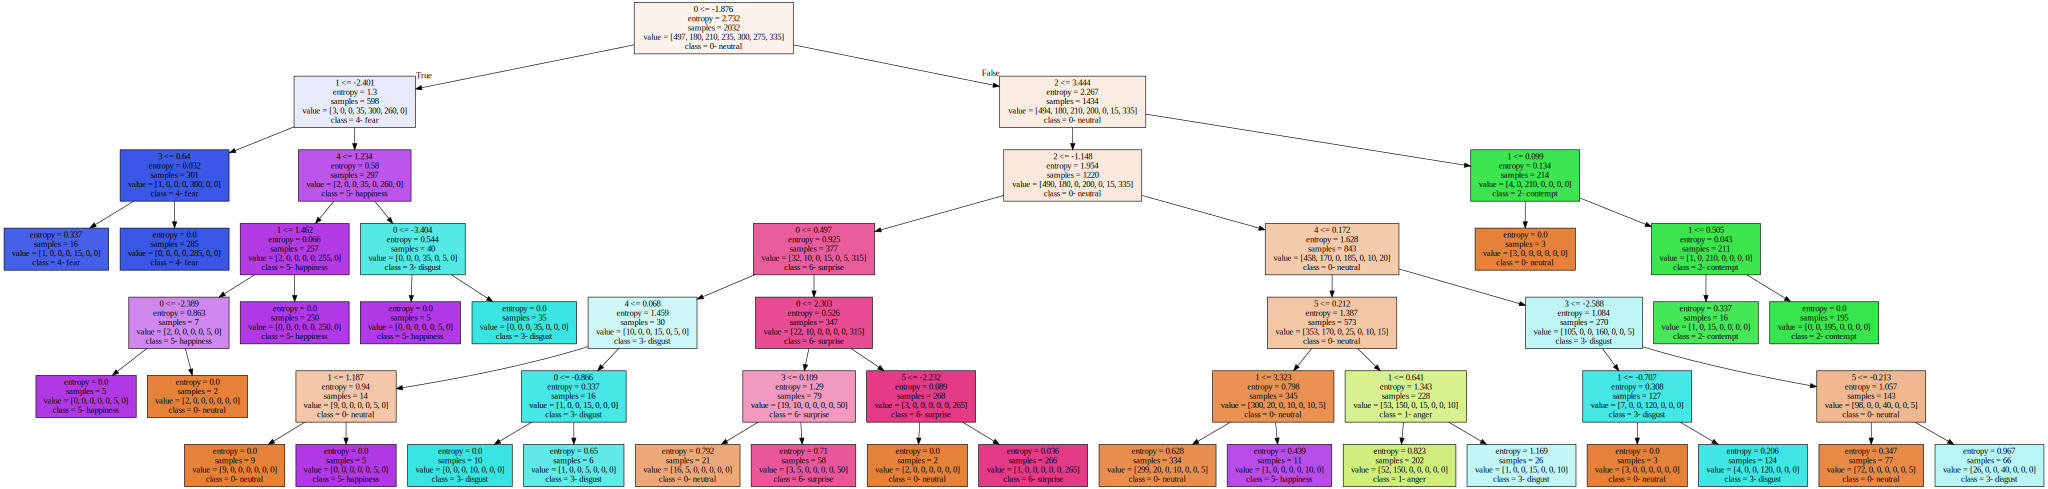

In [398]:
best_tree=search.best_estimator_
clf_best=best_tree
graph=Source(tree.export_graphviz(best_tree, out_file=None
                                  , feature_names=list(X_train)
                                  , class_names=['0- neutral', '1- anger', '2- contempt', '3- disgust',
         '4- fear', '5- happiness', '6- surprise']
                                  , filled=True)) 
display(SVG(graph.pipe(format='svg')))

In [399]:
train_accuracy = clf_best.score(X_train, y_train)
test_accuracy = clf_best.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (test_accuracy, 2))

Точность модели на обучающей выборке:  0.93
Точность модели на тестовой выборке:  0.5


Матрица несоответствий метода "Дерево решений":



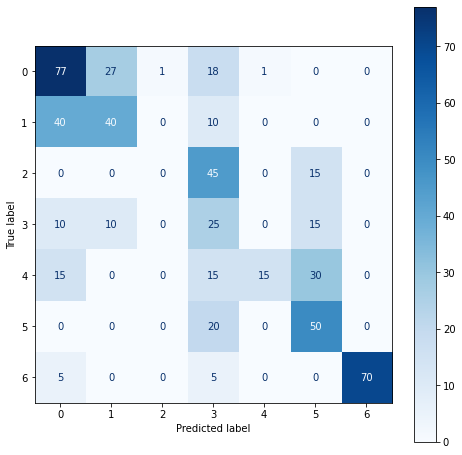

In [400]:
print('Матрица несоответствий метода "Дерево решений":\n')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, clf_best.predict(X_test)))
disp.plot(cmap = 'Blues', ax=ax);

In [401]:
print ('\n clasification report:\n', classification_report(y_test, clf_best.predict(X_test)))


 clasification report:
               precision    recall  f1-score   support

           0       0.52      0.62      0.57       124
           1       0.52      0.44      0.48        90
           2       0.00      0.00      0.00        60
           3       0.18      0.42      0.25        60
           4       0.94      0.20      0.33        75
           5       0.45      0.71      0.56        70
           6       1.00      0.88      0.93        80

    accuracy                           0.50       559
   macro avg       0.52      0.47      0.45       559
weighted avg       0.55      0.50      0.48       559



__Итог: accuracy = 50%__

## Random Forest

In [513]:
clf = RandomForestClassifier(random_state=17)
par = {'n_estimators': range(15, 20), 'max_depth' : range(2, 5)}
search = GridSearchCV(clf, par, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

{'max_depth': 4, 'n_estimators': 15}

In [514]:
clf_best_rf = search.best_estimator_
clf_best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=15, random_state=17)

In [515]:
train_accuracy_rf = clf_best_rf.score(X_train, y_train)
test_accuracy_rf = clf_best_rf.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (train_accuracy_rf, 2))
print ('Точность модели на тестовой выборке: ', round (test_accuracy_rf, 2))

Точность модели на обучающей выборке:  0.88
Точность модели на тестовой выборке:  0.54


Матрица несоответствий метода "Случайный лес":



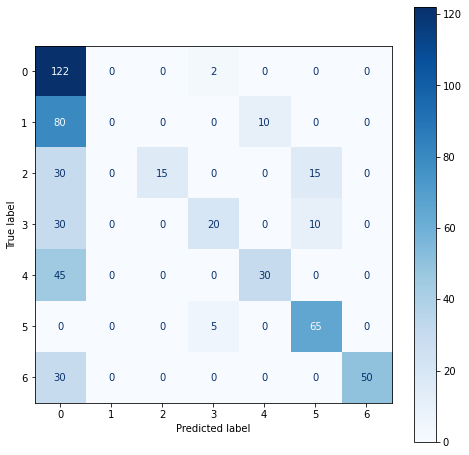

In [516]:
print('Матрица несоответствий метода "Случайный лес":\n')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, clf_best_rf.predict(X_test)))
disp.plot(cmap = 'Blues', ax=ax);

In [517]:
print ('\n clasification report:\n', classification_report(y_test, clf_best_rf.predict(X_test), zero_division=0))


 clasification report:
               precision    recall  f1-score   support

           0       0.36      0.98      0.53       124
           1       0.00      0.00      0.00        90
           2       1.00      0.25      0.40        60
           3       0.74      0.33      0.46        60
           4       0.75      0.40      0.52        75
           5       0.72      0.93      0.81        70
           6       1.00      0.62      0.77        80

    accuracy                           0.54       559
   macro avg       0.65      0.50      0.50       559
weighted avg       0.60      0.54      0.49       559



__Итог: accuracy = 54%__

## Метод адаптивного бустинга:

In [518]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,
                                                min_samples_split=20, min_samples_leaf=5), 
                         algorithm="SAMME",n_estimators=100, learning_rate=0.8)
bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=5,
                                                         min_samples_split=20),
                   learning_rate=0.8, n_estimators=100)

In [519]:
print ('\n clasification report:\n', classification_report(y_test, bdt.predict(X_test), zero_division=0))


 clasification report:
               precision    recall  f1-score   support

           0       0.33      0.87      0.48       124
           1       0.39      0.22      0.28        90
           2       0.00      0.00      0.00        60
           3       0.80      0.58      0.67        60
           4       1.00      0.40      0.57        75
           5       1.00      0.79      0.88        70
           6       0.80      0.56      0.66        80

    accuracy                           0.52       559
   macro avg       0.62      0.49      0.51       559
weighted avg       0.60      0.52      0.51       559



Найдем лучшие параметры вариируя параетры бустинга:

Матрица несоответствий метода "AdaBoost":



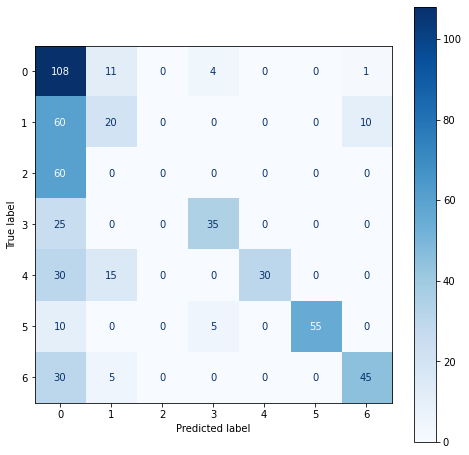

In [520]:
print('Матрица несоответствий метода "AdaBoost":\n')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, bdt.predict(X_test)))
disp.plot(cmap = 'Blues', ax=ax);

__Итог: accuracy = 52%__

## Метод Градиентного бустинга:

Подберем наилучший параметр learning rate:

In [293]:
# define the model with default hyperparameters
model = GradientBoostingClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [30, 50, 100]
grid['learning_rate'] = [0.1]
grid['max_depth'] = [2, 3, 4]
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid,
                           n_jobs=-1, cv=10, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.989662 using {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.961605 (0.017039) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 30}
0.973911 (0.015587) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
0.983761 (0.009357) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
0.976376 (0.012225) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 30}
0.983758 (0.010345) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0.985724 (0.011116) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.983751 (0.012081) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 30}
0.986214 (0.011194) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}
0.989662 (0.006775) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


Матрица несоответствий метода "Градиентный бустинг":



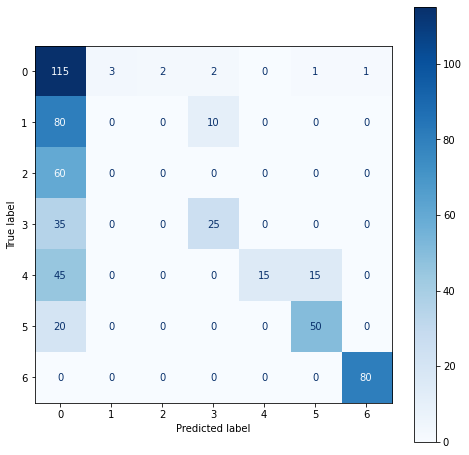

In [294]:
print('Матрица несоответствий метода "Градиентный бустинг":\n')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, grid_result.predict(X_test)))
disp.plot(cmap = 'Blues', ax=ax);

In [295]:
print ('\n clasification report:\n', classification_report(y_test, grid_result.predict(X_test)))


 clasification report:
               precision    recall  f1-score   support

           0       0.32      0.93      0.48       124
           1       0.00      0.00      0.00        90
           2       0.00      0.00      0.00        60
           3       0.68      0.42      0.52        60
           4       1.00      0.20      0.33        75
           5       0.76      0.71      0.74        70
           6       0.99      1.00      0.99        80

    accuracy                           0.51       559
   macro avg       0.53      0.47      0.44       559
weighted avg       0.51      0.51      0.44       559



__Итог: accuracy = 51%__

## Логистическая регрессия

Точность модели на обучающей выборке:  0.92
Точность модели на тестовой выборке:  0.57
Матрица несоответствий метода "Логистическая регрессия":



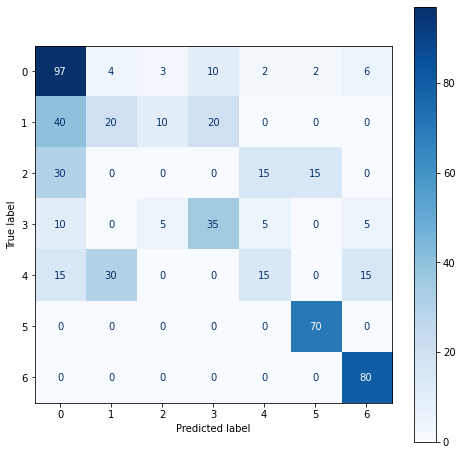

In [296]:
LR_model = LogisticRegression(solver='liblinear')
# Обучим модель на обучающей выборке
LR_model.fit(X_train, y_train) 
# Предскажем класс тестовой выборки
LR_prediction = LR_model.predict(X_test) 

LR_train_accuracy = LR_model.score(X_train, y_train)
LR_test_accuracy = LR_model.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (LR_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (LR_test_accuracy, 2))

print('Матрица несоответствий метода "Логистическая регрессия":\n')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, LR_model.predict(X_test)))
disp.plot(cmap = 'Blues', ax=ax);

In [297]:
print ('\n clasification report:\n', classification_report(y_test, LR_model.predict(X_test)))


 clasification report:
               precision    recall  f1-score   support

           0       0.51      0.78      0.61       124
           1       0.37      0.22      0.28        90
           2       0.00      0.00      0.00        60
           3       0.54      0.58      0.56        60
           4       0.41      0.20      0.27        75
           5       0.80      1.00      0.89        70
           6       0.75      1.00      0.86        80

    accuracy                           0.57       559
   macro avg       0.48      0.54      0.50       559
weighted avg       0.49      0.57      0.51       559



__Итог: accuracy = 57%__

## KNN

Точность модели на обучающей выборке:  0.96
Точность модели на тестовой выборке:  0.57
Матрица несоответствий метода "KNN":



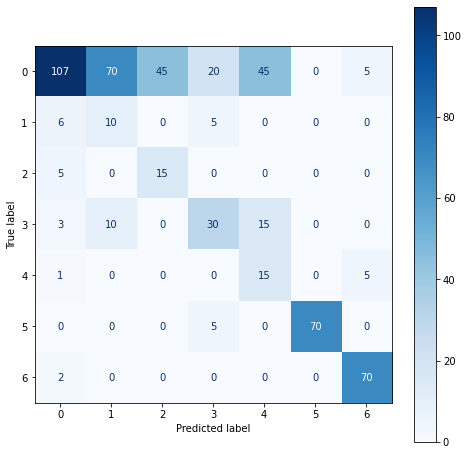

In [440]:
KNN_model = KNeighborsClassifier(n_neighbors = 10)
KNN_model.fit(X_train, y_train)
KNN_prediction = KNN_model.predict(X_test)

KNN_train_accuracy = KNN_model.score(X_train, y_train)
KNN_test_accuracy = KNN_model.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (KNN_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (KNN_test_accuracy, 2))

fig, ax = plt.subplots(figsize=(8, 8))
print('Матрица несоответствий метода "KNN":\n')
disp = ConfusionMatrixDisplay(confusion_matrix(KNN_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

In [441]:
print ('\n clasification report:\n', classification_report(y_test, KNN_prediction))


 clasification report:
               precision    recall  f1-score   support

           0       0.37      0.86      0.51       124
           1       0.48      0.11      0.18        90
           2       0.75      0.25      0.38        60
           3       0.52      0.50      0.51        60
           4       0.71      0.20      0.31        75
           5       0.93      1.00      0.97        70
           6       0.97      0.88      0.92        80

    accuracy                           0.57       559
   macro avg       0.68      0.54      0.54       559
weighted avg       0.65      0.57      0.53       559



__Итог: accuracy = 57%__

## Наивный байесовский алгоритм классификации:

Точность модели на обучающей выборке:  0.94
Точность модели на тестовой выборке:  0.54
Матрица несоответствий метода "Наивный байесовский алгоритм":



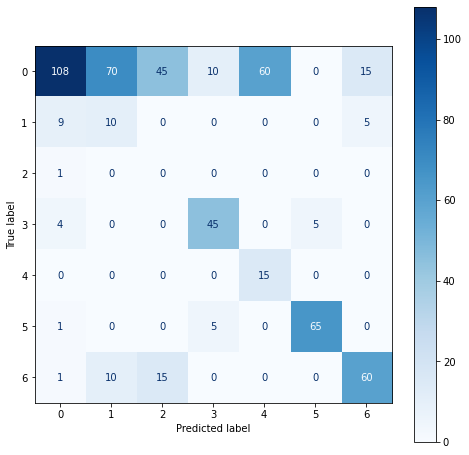

In [521]:
GNB_model = GaussianNB() 
GNB_model.fit(X_train, y_train)
GNB_prediction = GNB_model.predict(X_test) 

GNB_train_accuracy = GNB_model.score(X_train, y_train)
GNB_test_accuracy = GNB_model.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (GNB_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (GNB_test_accuracy, 2))

fig, ax = plt.subplots(figsize=(8, 8))
print('Матрица несоответствий метода "Наивный байесовский алгоритм":\n')
disp = ConfusionMatrixDisplay(confusion_matrix(GNB_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

In [522]:
print ('\n clasification report:\n', classification_report(y_test, GNB_prediction, zero_division=0))


 clasification report:
               precision    recall  f1-score   support

           0       0.35      0.87      0.50       124
           1       0.42      0.11      0.18        90
           2       0.00      0.00      0.00        60
           3       0.83      0.75      0.79        60
           4       1.00      0.20      0.33        75
           5       0.92      0.93      0.92        70
           6       0.70      0.75      0.72        80

    accuracy                           0.54       559
   macro avg       0.60      0.52      0.49       559
weighted avg       0.58      0.54      0.49       559



__Итог: accuracy = 54%__

## Метод опорных векторов:

Точность модели на обучающей выборке:  0.94
Точность модели на тестовой выборке:  0.53
Матрица несоответствий метода опорных векторов:



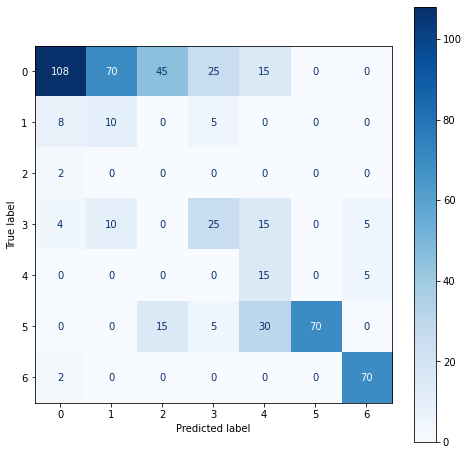

In [427]:
SVC_model = SVC(gamma='scale', kernel='poly', degree=1) 
SVC_model.fit(X_train, y_train)
SVC_prediction = SVC_model.predict(X_test) 

SVC_train_accuracy = SVC_model.score(X_train, y_train)
SVC_test_accuracy = SVC_model.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (SVC_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (SVC_test_accuracy, 2))

fig, ax = plt.subplots(figsize=(8, 8))
print('Матрица несоответствий метода опорных векторов:\n')
disp = ConfusionMatrixDisplay(confusion_matrix(SVC_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

In [305]:
print ('\n clasification report:\n', classification_report(y_test, SVC_prediction))


 clasification report:
               precision    recall  f1-score   support

           0       0.40      0.87      0.54       124
           1       0.49      0.22      0.31        90
           2       0.00      0.00      0.00        60
           3       0.48      0.50      0.49        60
           4       0.75      0.20      0.32        75
           5       0.99      1.00      0.99        70
           6       0.95      1.00      0.98        80

    accuracy                           0.58       559
   macro avg       0.58      0.54      0.52       559
weighted avg       0.58      0.58      0.53       559



__Итог: accuracy = 53%__

**После проведения снижения размерности после PCA на LDA мы получили выше предсказательные способности всех классификаторов.**

**Высокие уровни точности показали: Адаптивный бустинг после PCA и LDA (54%), Логистическая регрессия после PCA и LDA (57%), KNN после PCA и LDA (59%)**

### ВЫВОД:

### Таким образом, лучшими алгоритмомами для данной задачи стали алгоритм К ближайших соседей с параметром K=10, осуществеленный после снижения размерности с помощью метода главных компонент (оставление 90 % дисперсии) и последовательно примененного линейного дискриминантного анализа для снижения размерности до величины числа классов - 1 (до 6 признаков) (acc = 59%), а также ЛДА в качестве классификатора после снижения размерности с помощью МГК (acc = 64%).